In [ ]:
!pip install --upgrade pip
!pip install --upgrade datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 136.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 144.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 160.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 42.6 M

In [ ]:
from huggingface_hub import login
login()

In [ ]:
import os
import zipfile
from datasets import Dataset, Audio
import pandas as pd

# 2. Giải nén files
def extract_zip(zip_path, extract_path):
    """Giải nén file zip"""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# 3. Tạo mapping giữa audio và transcript
def create_dataset_dict(audio_dir, transcript_dir):
    """Tạo dictionary chứa đường dẫn audio và nội dung transcript"""
    dataset_dict = []

    # Lấy danh sách file audio
    audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]

    for audio_file in audio_files:
        # Tìm file transcript tương ứng
        transcript_file = audio_file.replace('.wav', '.txt')
        transcript_path = os.path.join(transcript_dir, transcript_file)

        if os.path.exists(transcript_path):
            # Đọc nội dung transcript
            with open(transcript_path, 'r', encoding='utf-8') as f:
                text = f.read().strip()

            dataset_dict.append({
                'audio': os.path.join(audio_dir, audio_file),
                'text': text
            })

    return dataset_dict

# 4. Tạo Dataset
def create_audio_dataset(audio_dir, transcript_dir):
    """Tạo Hugging Face Dataset với audio và text"""
    # Tạo dictionary data
    data_dict = create_dataset_dict(audio_dir, transcript_dir)

    # Chuyển thành DataFrame
    df = pd.DataFrame(data_dict)

    # Tạo Dataset
    dataset = Dataset.from_pandas(df)

    # Thêm tính năng Audio
    dataset = dataset.cast_column('audio', Audio())

    return dataset

In [ ]:
repo_id="huytran98/vin-bigdata-vi-audio"
local_dir_path="./vin-dataset"
model_id="openai/whisper-small"
output_repo_id="huytran98/whisper-small-vin-data"

In [ ]:
from huggingface_hub import snapshot_download
import os

local_dir = snapshot_download(
    repo_type="dataset",
    repo_id=repo_id,
    local_dir=local_dir_path
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

transcript.zip:   0%|          | 0.00/445k [00:00<?, ?B/s]

audio.zip:   0%|          | 0.00/261M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/2.46k [00:00<?, ?B/s]

In [ ]:
# Giải nén audio và transcript
audio_zip = os.path.join(local_dir, "audio.zip")
transcript_zip = os.path.join(local_dir, "transcript.zip")

audio_extract_dir = os.path.join(local_dir, "")
transcript_extract_dir = os.path.join(local_dir, "")

extract_zip(audio_zip, audio_extract_dir)
extract_zip(transcript_zip, transcript_extract_dir)

In [ ]:
from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperProcessor, WhisperForConditionalGeneration

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_id)

tokenizer = WhisperTokenizer.from_pretrained(model_id, language="vietnamese", task="transcribe")

processor = WhisperProcessor.from_pretrained(model_id, language="vietnamese", task="transcribe")

model = WhisperForConditionalGeneration.from_pretrained(model_id)

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

In [ ]:
# Load và kiểm tra dataset
audio_destination_dir = os.path.join(local_dir, "audio")
transcript_destination_dir = os.path.join(local_dir, "transcript")
dataset = create_audio_dataset(audio_destination_dir, transcript_destination_dir)

# Filter dataset
def filter_long_texts(batch):
    # Tokenize không truncate để lấy độ dài thực
    tokenized = processor.tokenizer(
        batch["text"],
        truncation=False
    )

    # Tạo mask cho các mẫu có độ dài hợp lệ
    valid_mask = [len(ids) <= 448 for ids in tokenized.input_ids]

    # In thống kê
    total = len(batch["text"])
    kept = sum(valid_mask)
    filtered = total - kept
    print(f"Filtered {filtered} samples out of {total} (keeping {kept} samples with length <= 448)")

    # Filter tất cả các cột theo mask
    return {
        key: [value for value, is_valid in zip(values, valid_mask) if is_valid]
        for key, values in batch.items()
    }

# Áp dụng filter
dataset = dataset.map(
    filter_long_texts,
    batched=True,
    remove_columns=dataset.column_names,
    num_proc=4
)

dataset

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Filtered 1 samples out of 250 (keeping 249 samples with length <= 448)
Filtered 0 samples out of 250 (keeping 250 samples with length <= 448)
Filtered 0 samples out of 250 (keeping 250 samples with length <= 448)
Filtered 0 samples out of 250 (keeping 250 samples with length <= 448)


Dataset({
    features: ['audio', 'text'],
    num_rows: 999
})

In [ ]:
# Kiểm tra một vài mẫu
print("Columns:", dataset.column_names)
print("\nFirst few examples:")
for idx in range(min(3, len(dataset))):
    example = dataset[idx]
    print(f"\nExample {idx + 1}:")
    print(f"Audio path: {example['audio']}")
    print(f"Text: {example['text']}")
    print(f"Text: {len(example['text'])}")
    # Audio array shape sẽ được load khi cần
    audio = dataset[idx]['audio']
    print(f"Audio array shape: {audio['array'].shape}")
    print(f"Sampling rate: {audio['sampling_rate']}")

Columns: ['audio', 'text']

First few examples:

Example 1:
Audio path: {'path': None, 'array': array([ 0.01550293,  0.02062988, -0.01757812, ..., -0.01739502,
        0.01785278,  0.00241089]), 'sampling_rate': 16000}
Text: mà mạ mình lấy bùn cho
Text: 22
Audio array shape: (29760,)
Sampling rate: 16000

Example 2:
Audio path: {'path': None, 'array': array([ 0.23583984,  0.2694397 ,  0.30688477, ..., -0.01751709,
       -0.01669312, -0.01489258]), 'sampling_rate': 16000}
Text: <unk> cái này là cái cái họng này thì như vậy á thì chúng ta thấy được cái vị trí rõ hơn tức là viêm cái vùng trong này ta kêu là viêm viêm họng
Text: 144
Audio array shape: (126880,)
Sampling rate: 16000

Example 3:
Audio path: {'path': None, 'array': array([ 9.15527344e-05, -5.18798828e-04,  7.93457031e-04, ...,
       -5.10559082e-02, -4.12902832e-02, -2.74658203e-02]), 'sampling_rate': 16000}
Text: hãng thông tấn a ép pi hôm hai mươi tháng mười hai trích lời một giới chức cấp cao của hoa kỳ nói rằng trong th

In [ ]:
 # Train/test
splits = dataset.train_test_split(test_size=0.2, seed=42)
print("\nDataset splits:")
print(f"Train: {len(splits['train'])} examples")
print(f"Test: {len(splits['test'])} examples")
sample = splits['train'][0]
print("\nSample:")
print(f"Audio path: {sample['audio']}")
print(f"Text: {sample['text']}")


Dataset splits:
Train: 799 examples
Test: 200 examples

Sample:
Audio path: {'path': None, 'array': array([-0.04385376, -0.04324341, -0.04388428, ...,  0.13174438,
        0.11898804,  0.10675049]), 'sampling_rate': 16000}
Text: không cứ sinh tố đê mà tất cả các sinh tố có ở chúng ta đều không cần dùng đến các


In [ ]:
# Test tokenizer
input_str = splits["train"][0]["text"]
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

Input:                 không cứ sinh tố đê mà tất cả các sinh tố có ở chúng ta đều không cần dùng đến các
Decoded w/ special:    <|startoftranscript|><|vi|><|transcribe|><|notimestamps|>không cứ sinh tố đê mà tất cả các sinh tố có ở chúng ta đều không cần dùng đến các<|endoftext|>
Decoded w/out special: không cứ sinh tố đê mà tất cả các sinh tố có ở chúng ta đều không cần dùng đến các
Are equal:             True


In [ ]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["text"]).input_ids

    return batch

In [ ]:
splits = splits.map(prepare_dataset, remove_columns=splits.column_names["train"], num_proc=4)

Map (num_proc=4):   0%|          | 0/799 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
model.generation_config.language = "vietnamese"
model.generation_config.task = "transcribe"
model.generation_config.forced_decoder_ids = None

In [ ]:
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

In [ ]:
import evaluate

metric = evaluate.load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}


In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir=output_repo_id,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=5000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=splits["train"],
    eval_dataset=splits["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

<ipython-input-19-8bb1332dfb1a>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()

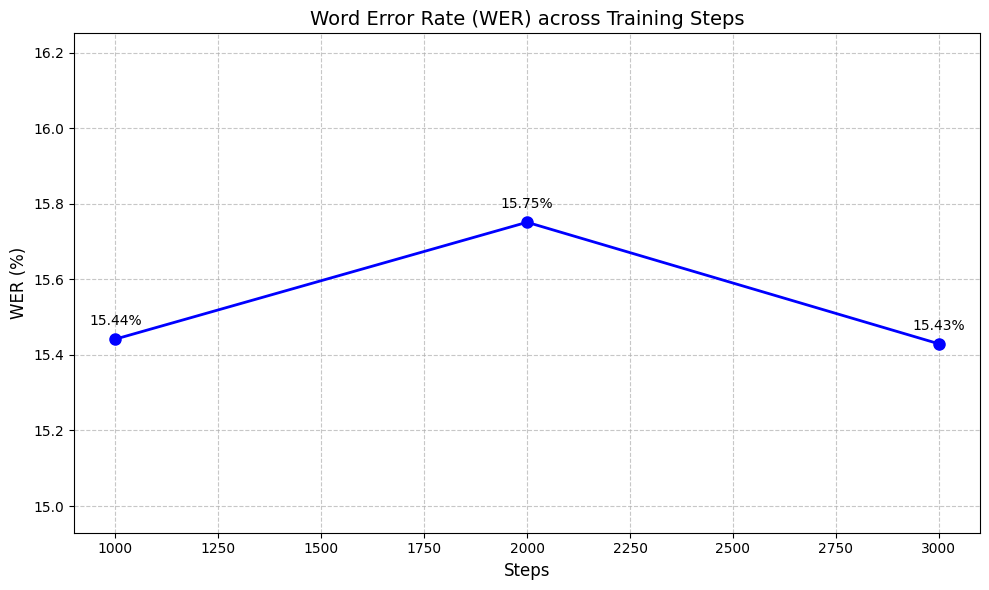

In [ ]:
import matplotlib.pyplot as plt

# Data
steps = [1000, 2000, 3000]
wer = [15.441722, 15.751052, 15.429349]

# Tạo figure
plt.figure(figsize=(10, 6))

# Vẽ đường WER
plt.plot(steps, wer, marker='o', color='blue', linewidth=2, markersize=8)

# Tùy chỉnh đồ thị
plt.title('Word Error Rate (WER) across Training Steps', fontsize=14)
plt.xlabel('Steps', fontsize=12)
plt.ylabel('WER (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Thêm giá trị trên các điểm
for i in range(len(steps)):
    plt.annotate(f'{wer[i]:.2f}%',
                (steps[i], wer[i]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

# Điều chỉnh trục y để dễ nhìn
plt.ylim(min(wer) - 0.5, max(wer) + 0.5)

plt.tight_layout()
plt.show()